In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import catboost

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e23/sample_submission.csv
/kaggle/input/playground-series-s3e23/train.csv
/kaggle/input/playground-series-s3e23/test.csv


In [2]:
train_path = '/kaggle/input/playground-series-s3e23/train.csv'
test_path = '/kaggle/input/playground-series-s3e23/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
target = 'defects'

In [3]:
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [4]:
train[target] = train[target].astype(int)
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0


In [5]:
train.shape

(101763, 23)

In [6]:
train[target].value_counts()

defects
0    78699
1    23064
Name: count, dtype: int64

In [7]:
train.dtypes

id                     int64
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                int64
dtype: object

In [8]:
train.isnull().sum()

id                   0
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [9]:
train = train.set_index('id')
test_ids = test['id']
test = test.set_index('id')

In [10]:
X = train.drop(target, axis=1)
y = train[target]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

# EDA

In [12]:
train.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,...,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549,0.226644
std,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,...,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769,0.418663
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,...,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000,0.000000
50%,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,...,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000,0.000000
75%,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,...,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000,0.000000
max,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,...,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000,1.000000


<Axes: >

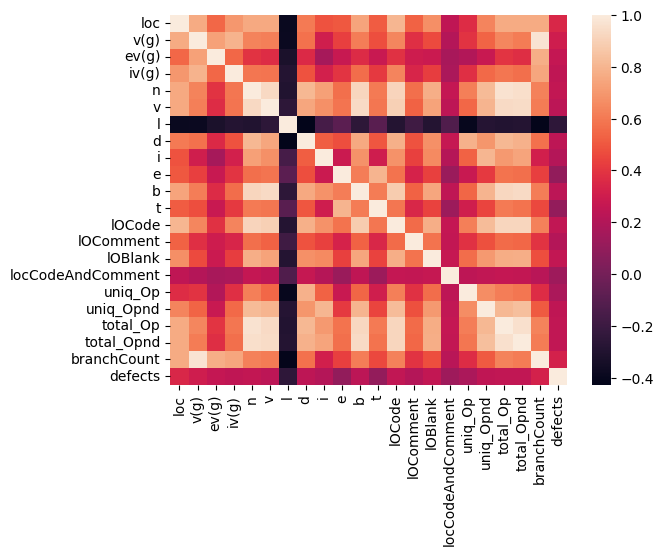

In [13]:
sns.heatmap(train.corr())

In [14]:
def t_score(x,y):
    def calc_stats(x):
        return np.mean(x), np.var(x), len(x)
    
    mu0, s0, n0 = calc_stats([x[y==0.0]])
    mu1, s1, n1 = calc_stats([x[y==1.0]])
    return np.abs(mu1-mu0) / np.sqrt(s0/n0 + s1/n1)

In [15]:
feature_name = X_train.columns.tolist()

In [16]:
feature_names = X_train.columns.to_numpy()
importance_list = []
for i in feature_names:
    importance_list.append(t_score(X_train[i], y_train))
    print(i, '\t', t_score(X_train[i], y_train))

loc 	 0.4902262058000643
v(g) 	 0.4200342218597942
ev(g) 	 0.3656444110152351
iv(g) 	 0.34434498009350434
n 	 0.35766776534246975
v 	 0.3105279928183126
l 	 0.4688724015687474
d 	 0.3469233307423051
i 	 0.2974857256033676
e 	 0.12244503345774789
b 	 0.30540329230211904
t 	 0.1273189571361092
lOCode 	 0.3459229245744551
lOComment 	 0.2706562411863692
lOBlank 	 0.3607414904330541
locCodeAndComment 	 0.1759146642907706
uniq_Op 	 0.2580675991671196
uniq_Opnd 	 0.33526811097110176
total_Op 	 0.3441683939992065
total_Opnd 	 0.3460319706522072
branchCount 	 0.4576384155750799


In [17]:
# good_features = ['loc', 'l', 'branchCount', 'v(g)']

# CatBoost

In [18]:
from catboost import CatBoostClassifier

In [19]:
model = CatBoostClassifier(iterations = 10000, learning_rate=0.01)

In [20]:
model.fit(X_train, y_train)

0:	learn: 0.6873086	total: 77.1ms	remaining: 12m 50s
1:	learn: 0.6815220	total: 96.1ms	remaining: 8m
2:	learn: 0.6759004	total: 109ms	remaining: 6m 4s
3:	learn: 0.6704682	total: 123ms	remaining: 5m 8s
4:	learn: 0.6650987	total: 137ms	remaining: 4m 33s
5:	learn: 0.6598389	total: 151ms	remaining: 4m 11s
6:	learn: 0.6547234	total: 167ms	remaining: 3m 57s
7:	learn: 0.6496814	total: 181ms	remaining: 3m 45s
8:	learn: 0.6446965	total: 195ms	remaining: 3m 36s
9:	learn: 0.6399933	total: 209ms	remaining: 3m 28s
10:	learn: 0.6352965	total: 223ms	remaining: 3m 22s
11:	learn: 0.6307812	total: 237ms	remaining: 3m 17s
12:	learn: 0.6264123	total: 252ms	remaining: 3m 13s
13:	learn: 0.6221613	total: 265ms	remaining: 3m 9s
14:	learn: 0.6179666	total: 283ms	remaining: 3m 8s
15:	learn: 0.6138699	total: 299ms	remaining: 3m 6s
16:	learn: 0.6098203	total: 313ms	remaining: 3m 4s
17:	learn: 0.6056928	total: 328ms	remaining: 3m 1s
18:	learn: 0.6018923	total: 341ms	remaining: 2m 59s
19:	learn: 0.5982195	total: 35

In [21]:
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_val = model.predict_proba(X_val)
y_pred_train = model.predict(X_train)

In [22]:
print('Train: ', roc_auc_score(np.array(y_train), y_pred_proba_train[:, 1]))
print('Test: ', roc_auc_score(np.array(y_val), y_pred_proba_val[:, 1]))

Train:  0.8438057546641171
Test:  0.7924079731491038


In [23]:
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
y_pred_proba_train

array([[0.56306354, 0.43693646],
       [0.91003478, 0.08996522],
       [0.96505938, 0.03494062],
       ...,
       [0.96327365, 0.03672635],
       [0.93647938, 0.06352062],
       [0.69288479, 0.30711521]])

## Submission

In [25]:
y_pred_proba_test = model.predict_proba(test)

In [26]:
submission = pd.DataFrame({'id': test_ids, 'defects': y_pred_proba_test[:, 1]})

In [27]:
submission.to_csv('submission.csv',index=False)